In [1]:
# Importy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp, NoPlot

# Sprawdzenie czy folder na wyniki istnieje
os.makedirs('../results/figures', exist_ok=True)

print("TopFarm imports successful!")

TopFarm imports successful!


/home/codespace/.local/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


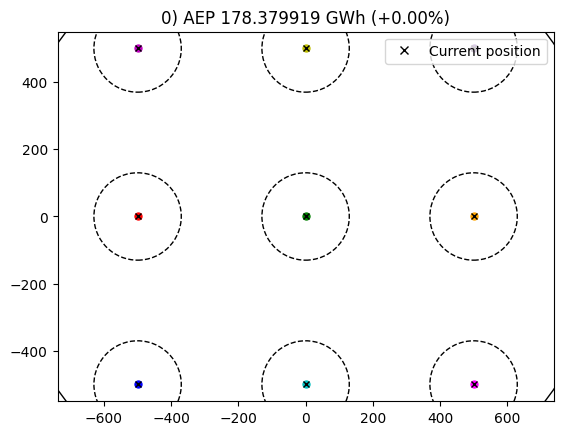

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


AttributeError: 'PyWakeAEPCostModelComponent' object has no attribute 'cost'

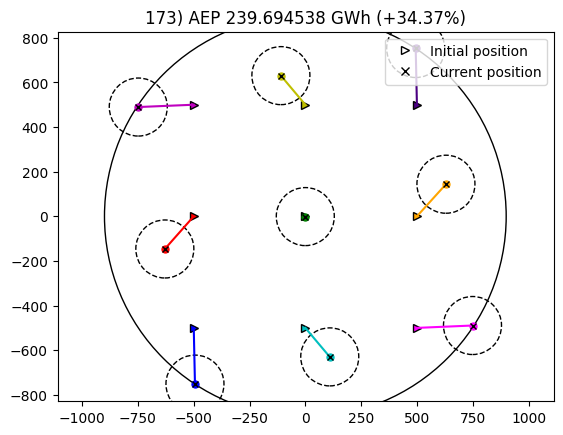

In [2]:
# 1. Konfiguracja
n_wt = 9
x_init, y_init = get_iea37_initial(n_wt).T

# 2. Komponenty TopFarm
cost_comp = get_iea37_cost(n_wt)
constraints = get_iea37_constraints(n_wt)
driver = EasyScipyOptimizeDriver()
plot_comp = XYPlotComp()

# 3. Definicja Problemu
tf_problem = TopFarmProblem(
    design_vars={'x': x_init, 'y': y_init},
    cost_comp=cost_comp,
    constraints=constraints,
    driver=driver,
    plot_comp=plot_comp
)

# 4. Uruchomienie (optymalizacja)
state = tf_problem.optimize()

# 5. Wyniki
print(f"Start AEP: {tf_problem.cost_comp.cost(x_init, y_init)}")
print(f"Optimized AEP: {state['cost']}") # W IEA37 cost to często wake loss lub AEP (zależy od implementacji, sprawdź output)

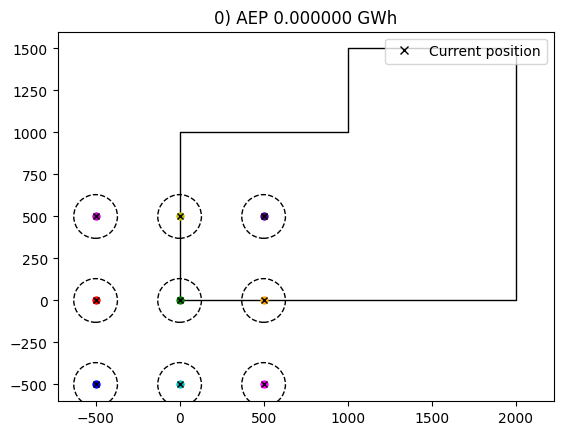

ValueError: 'cost_comp' <class PyWakeAEPCostModelComponent>: Error calling compute_partials(), Turbines 0 and 1 are at the same position
Turbines 0 and 3 are at the same position
Turbines 0 and 4 are at the same position
Turbines 1 and 0 are at the same position
Turbines 1 and 3 are at the same position
Turbines 1 and 4 are at the same position
Turbines 2 and 5 are at the same position
Turbines 3 and 0 are at the same position
Turbines 3 and 1 are at the same position
Turbines 3 and 4 are at the same position
Turbines 4 and 0 are at the same position
Turbines 4 and 1 are at the same position
Turbines 4 and 3 are at the same position
Turbines 5 and 2 are at the same position
Turbines 6 and 7 are at the same position
Turbines 7 and 6 are at the same position

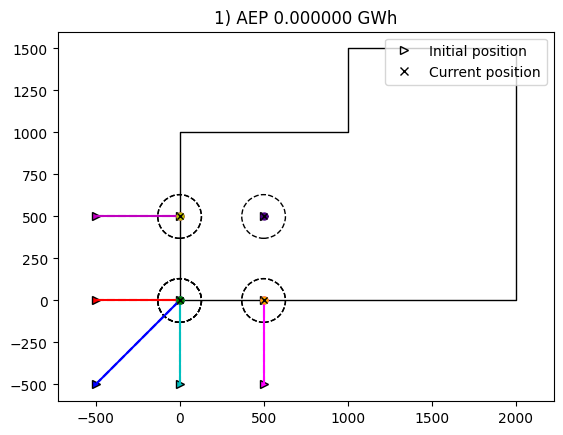

In [5]:
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

# Definicja niestandardowej granicy (Polygon) - np. prostokąt z wycięciem
boundary_verts = np.array([
    [0, 0], [2000, 0], [2000, 1500], [1000, 1500], [1000, 1000], [0, 1000], [0, 0]
])

# Parametryzacja średnicy
D = 130 

# Pętla eksperymentalna dla Sprintu 2
spacing_factors = [2, 3, 4]
results_sprint2 = []

for factor in spacing_factors:
    min_dist = factor * D
    
    # Definicja ograniczeń
    # Uwaga: Boundary constraint wymaga listy krotek lub array
    my_constraints = [
        XYBoundaryConstraint(boundary_verts, 'polygon'),
        SpacingConstraint(min_dist)
    ]
    
    # Setup problemu (użyj tego samego cost_comp i driver co wcześniej)
    problem = TopFarmProblem(
        design_vars={'x': x_init, 'y': y_init}, # Reset do pozycji startowych!
        cost_comp=cost_comp,
        constraints=my_constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp() # Use XYPlotComp so we can call plot_current_position
    )
    
    # Optymalizacja
    tic = time.time()
    state = problem.optimize()
    toc = time.time()
    
    # Zapisz wynik
    results_sprint2.append({
        'min_dist_factor': factor,
        'aep': state['cost'], # Sprawdź czy cost to AEP czy strata
        'time': toc - tic
    })
    
    # Wykres
    plt.figure()
    problem.plot_comp.plot_current_position(state['x'], state['y'])
    plt.title(f"Layout with {factor}D Spacing")
    plt.savefig(f"../results/figures/sprint2_spacing_{factor}D.png")
    plt.close()

# Wyświetl tabelkę w notebooku
pd.DataFrame(results_sprint2)
